# Load raw data and save as a netcdf

- Change the output file format.  This could go straight into an xarray/netcdf rather than a pickle
- Change the download of timeseries/ data to only load an update to the time series, and then merge with  data that was already downloaded.  Should be faster
- Add Wetlabs data to be downloaded: Not currently downloading.
 
As of 27 Jan 2022: Combined what 01-load_raw_data.ipynb and 02-process-data.ipynb did 

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import json
from io import StringIO
import requests
from setdir import *
import ast # To handle the string conversion when loading json file

# User defined options: Gliders and variables, start date

## This might be a good place to assign units to variables??

In [70]:
# Slocum gliders: A dictionary with the key as the serial number ('unit_398') 
# and then the plain text name, "Churchill"
glider_names = {
#    'unit_409': 'Grease',
    'unit_398': 'Churchill',
}

# Choose a start date.  
# Earliest valid data for TERIFIC was 2021-12-12, but there were some in-air 
# measurements before
mission_startdate = '2021-12-12'

# Choose variable names
# Check the Slocum master data list 8.2 for a range of options
var_physics = ['sci_water_pressure', 'sci_water_temp', 'sci_water_cond',
            'sci_oxy4_oxygen',
            'derived_salinity',
            'derived_potential_density', 'derived_potential_temperature',
            'm_gps_lon', 'm_gps_lat',
           ]

# Wetlabs on Unit_398: these parameters seem to work (bb2flsv9)
wetlabs398 = ['sci_bb2flsv9_b532_scaled', # units ug/l  - blue?? or green
            'sci_bb2flsv9_b700_scaled', # units ug/l - red
            'sci_bb2flsv9_chl_scaled', # units ug/l
           ]

# Wetlabs on unit_409: these parameters seem to work (flbbcd)
wetlabs409 = ['sci_flbbcd_cdom_units', # ppb - 409
              'sci_flbbcd_chlor_units', # ug/l
              'sci_flbbcd_bb_units', # ??? is this blue backscatter?
             ]


# Some details for the attributes in the netcdf file.
platform_type = 'slocum'
project_name = 'TERIFIC'
institution_name = 'National Oceanography Centre, UK'



## Get a token

https://api.c2.noc.ac.uk/charon/tokens/issue



In [62]:
# Need to copy and paste the token you generated by logging in at the website
# above into the file myToken.txt
with open("myToken.txt", "r") as myfile:
    myToken = myfile.read().replace('\n', '')
    
from requests.structures import CaseInsensitiveDict
headers = CaseInsensitiveDict()
headers["Accept"] = "application/json"
headers["Authorization"] = f'Bearer {myToken}'



## API request options for gliders (both data and positioning)

For time series data, the website is: https://api.c2.noc.ac.uk/timeseries/doc
Check under 'meta/variables' to see what variables can be selected.

Be sure to choose platform: slocum and serial number: unit_409 or unit_398



An example to download time series data is 
https://api.c2.noc.ac.uk/timeseries/observations/csv_combined?variable=sci_water_pressure&variable=sci_water_temp&variable=sci_water_cond&variable=sci_oxy4_oxygen&variable=sci_bb2flsv9_chl_scaled&variable=derived_salinity&variable=derived_potential_density&variable=derived_potential_temperature&platform_type=slocum&platform_serial=unit_409&reverse_order=false&skip_nulls=false&cached=false

Hmm. removed the wetlabs because it seemed to remove some of the 
data/discretise it so that not all the T&S came down

Note: for positioning data, it's: https://api.c2.noc.ac.uk/positions/doc

In [63]:
# Unit list for API
unit_list = [(k) for k in glider_names.keys()]

# URL for the data
api_root = 'https://api.c2.noc.ac.uk/'

# Platform type for API
platform = platform_type

# Format the time string
time_strf = '%Y%m%d'

# Used to chop data before this date
tstart = pd.Timestamp(mission_startdate+'T00')

# Change this to a later value to download only a subset of the data
download_startdate = mission_startdate+'T00%3A00%3A00'


# Loop through both gliders to download data

Goes through the serial numbers in unit_list and loads the data.  Not sure whether I want to cut the start, but will decide later.
Save a netcdf with the data in ../01-data/01-raw/

## Includes data-specific API request options

- api_choice
- var_str


### ISSUE: Set up a boolean to decide whether to use a time limited download (from dstart to present) or the full dataset including in-air measurements






In [86]:
#----------------------------------------------------------------------------
# DATA Download: API choices specific for data (not positioning)
#----------------------------------------------------------------------------

# Choice of API website:
# Not sure how many there are but for glider sensor data, it's timeseries/
api_choice = 'timeseries/observations/'

# Format for downloaded file:
# Using csv_combined_transposed rather than csv_combined since it seems to 
# help with getting all the data (not just when the wetlabs was on)
format_choice = 'csv_combined_transposed?'

# Format the variable list for the API
var_list = var_physics+wetlabs398+wetlabs409
var_str = ''
for i in var_list:
    var_str = var_str+'variable='+i+'&'

#----------------------------------------------------------------------------
# Some prep before looping
#----------------------------------------------------------------------------
# Check that the output directory exists
# If not, then exit
outpath = cat_interim_path('')
if not os.path.isdir(outpath):
   sys.exit(1)

# Date created (for attributes in netcdf file)
date_created = datetime.datetime.now().strftime(time_strf)


for i in unit_list:
    #--------------------------------------------------------------
    # Format the request
    #--------------------------------------------------------------
    if 0:
        # Time limited - can use this to make the dataset smaller when
        # testing changes.  Just use a later value for 'dstart'
        opt_str = f'from={download_startdate}&'\
        f'{var_str}platform_type={platform}'\
        f'&platform_serial{i}&reverse_order=false&skip_nulls=false'\
        '&cached=false'
        start_yyyymmdd = '_'+str.replace(dstart[0:10],'-','')
        
    # No time limiting - Download everything
    opt_str = f'{var_str}platform_type={platform}'\
    f'&platform_serial={i}&reverse_order=false&skip_nulls=false'\
    '&cached=false'
    start_yyyymmdd = ''

    # Concatinate request string
    url = api_root+api_choice+format_choice+opt_str

    #--------------------------------------------------------------
    # Request the data - save as text in variable 'resp'
    #--------------------------------------------------------------
    resp = requests.get(url, headers=headers)

    # Check the response code 
    # (200 is good.  If you get something else, token may need refreshing)
    if not resp.status_code==200:
        print(i+'[ resp '+str(resp.status_code)+' ] '\
              'Cannot access data - May need to refresh token?')
        print('Or check the url variable')
    else:
        print(i+'[ resp '+str(resp.status_code)+' ] '\
              'Good response code - parsing data')

        # Parse the 'resp' string into a dataFrame
        aa = resp.content.decode("utf-8") 
        data_df = pd.read_csv(StringIO(aa)) # Get rid of the leading b
        data_df = data_df.sort_values(['timestamp']) # Sort by time
 
        # Print a little table to the screen
        #    print(data_df.head(3))

        #--------------------------------------------------------------
        # Clean up time format and convert pressure units to dbar
        #--------------------------------------------------------------
        data_df['time'] = data_df.timestamp.apply(lambda x:
                                    datetime.datetime.fromtimestamp(x*0.001))
        data_df = data_df.drop(columns='timestamp')
        # Cut data to post deployment
        data_df_2021 = data_df[data_df.time>=tstart].copy()

        # Change pressure from bars to dbars
        data_df_2021['pressure_dbar'] =  data_df_2021.sci_water_pressure * 10

        # Remove negative salinities
        df1 = data_df_2021['derived_salinity']
        df2 = df1.where(df1>0)
        data_df_2021['derived_salinity'] = df2
        
        # ISSUE: Remove any variable where there are no valid values (all nan)

        #--------------------------------------------------------------
        # Format the output file name (and path in ../01-data/01-raw/
        #--------------------------------------------------------------
        # Prepare to convert to xarray
        data_df2 = data_df_2021
        data_df2 = data_df2.set_index("time")
        data_df2 = data_df2.drop(columns="sci_water_pressure")

        # Convert to xarray
        ds_2021 = data_df2.to_xarray()

        # Set some attributes
        maxtimestr = pd.to_datetime(ds_2021.time.values.max()).strftime(time_strf)

        # Create a dictionary of attributes
        attr_dict = {"Platform": platform,
                     "End Time": maxtimestr,
                     "Project": project_name,
                     "Institution": institution_name,
                     "Date created": date_created, 
                     "Serial number": i,
                     "Platform name": glider_names[i],
                }

        ds_2021 = ds_2021.assign_attrs(attr_dict)

        # Save a netcdf file
        outfile = i+'_'+maxtimestr+'.nc'
        outfile_with_path = cat_raw_path(outfile)

        ds_2021.to_netcdf(outfile_with_path)


unit_398[ resp 200 ] Good response code - parsing data
unit_409[ resp 200 ] Good response code - parsing data


# Get the position data separately

Example of a request
https://api.c2.noc.ac.uk/positions/positions?platform_type=slocum&platform_serial=unit_409&source_type=internal&time_order=descending




In [76]:
# Choose which of the api websites to use.. Not sure how many there are but 
# for these data, it's timeseries/
api_choice = 'positions/'
format_choice = 'positions?'

for i in unit_list:
    if 0:
        # Time limited
        opt_str = f'from={dstart}&platform_type={platform}'\
        f'&platform_serial={i}&source_type=internal&time_order=descending'
        start_yyyymmdd = '_'+str.replace(dstart[0:10],'-','')
    
    # No time limiting
    opt_str = f'platform_type={platform}'\
    f'&platform_serial={i}&source_type=internal&time_order=descending'
    start_yyyymmdd = ''

    # Concatenate request string
    url = api_root+api_choice+format_choice+opt_str

    # Get the data
    resp = requests.get(url, headers=headers)

    # Check the response code 
    # (200 is good.  If you get something else, token may need refreshing)
    if not resp.status_code==200:
        print(i+'[ resp '+str(resp.status_code)+' ] '\
              'Cannot access data - May need to refresh token?')
        print('Or check the url variable')
    else:
        print(i+'[ resp '+str(resp.status_code)+' ] '\
              'Good response code - parsing data')

        # Parse the string into a dataFrame
        json_string = resp.content.decode("utf-8") # Get rid of the leading b
        bb = ast.literal_eval(json_string)[0]
        data_df = pd.DataFrame(bb['positions']['internal'])
        data_df.head()

        #--------------------------------------------------------------
        # Format the output file name (and path in ../01-data/01-raw/
        #--------------------------------------------------------------
        # Prepare to convert to xarray
        data_df2 = data_df
        data_df2["time"] = data_df["time"].astype('datetime64').dt.round('1s')
        data_df2["time_received"] = data_df["time"].astype('datetime64').dt.round('1s')
        data_df2 = data_df2.set_index("time")
        data_df2 = data_df2.drop(columns="source")
        ds_pos = data_df2.to_xarray()

        maxtimestr = pd.to_datetime(ds_pos.time.values.max()).strftime(time_strf)


       # Create a dictionary of attributes
        attr_dict = {"Platform": platform+' glider',
                     "End Time": maxtimestr,
                     "Project": project_name,
                     "Institution": institution_name,
                     "Date created": date_created, 
                     "Serial number": i,
                      "Platform name": glider_names[i],


                }


        ds_pos = ds_pos.assign_attrs(attr_dict)


    # Save a netcdf file
    outfile = i+'_position_'+maxtimestr+'.nc'
    outfile_with_path = cat_raw_path(outfile)

    ds_pos.to_netcdf(outfile_with_path, 'w')



unit_398[ resp 200 ] Good response code - parsing data
unit_409[ resp 200 ] Good response code - parsing data


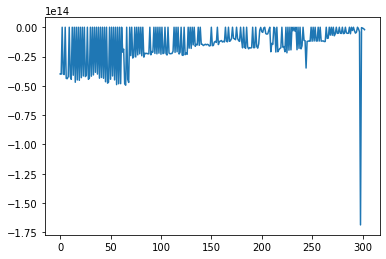

In [85]:
t2 = ds_pos['time'].values.astype('float')
plt.plot(np.diff(t2))

In [79]:
ds_pos

<xarray.Dataset>
Dimensions:        (time: 304)
Coordinates:
  * time           (time) datetime64[ns] 2022-01-27T01:13:45 ... 2021-12-08T1...
Data variables:
    time_received  (time) datetime64[ns] 2022-01-27T01:13:45 ... 2021-12-08T1...
    latitude       (time) float64 59.22 59.3 59.34 59.34 ... 60.72 60.72 60.72
    longitude      (time) float64 -57.24 -57.3 -57.34 ... -46.03 -46.03 -46.03
Attributes:
    Platform:       slocum glider
    End Time:       20220127
    Project:        TERIFIC
    Institution:    National Oceanography Centre, UK
    Date created:   20220127
    Serial number:  unit_409
    Platform name:  Grease